# Convolutional Neural Network

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used. Same as cnn-kaggle-v021

This notebook is set up for cross-validation, which is freq. used in research

# Changeable Parameters

_____________________________________________________________________

In [41]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 150000 # Set very high so it uses all the images in the directory, does not actually take 150,000 images

# Number of epochs
epoch_t = 35 # Seems to be optimal point

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# number of folds
n_folds = 10

_____________________________________________________________________

In [42]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [43]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import time

Check whether a, and which GPU is available for the computation

In [44]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [46]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/learning_curve"
    for files in os.listdir(dir):
        if "cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cgan-lc-cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/learning_curve/cgan-lc-cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

1 matches(es) found
--------------
New folder name: cgan-lc-cnn-local-v002
--------------


**Data**


In [47]:
if cenv == 0:
    path_root = "/kaggle/input/"
    path_root_gen = '/kaggle/input/cganlocalv007/'

if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/lc_original"
    path_root_gen = "C:/Users/Max/Documents/image_data/cgan-lc-ckpt"

Load the data. No data augmentation takes place

In [48]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 1000 images belonging to 11 classes.


Count number of files in the CGAN folder

In [49]:
batches_gen = ImageDataGenerator().flow_from_directory(
    directory     = path_root_gen, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs_gen, labels_gen = next(batches_gen)

Found 1602 images belonging to 10 classes.


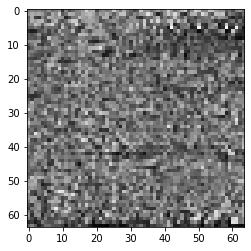

In [50]:
plt.imshow(imgs_gen[900],cmap='gray')

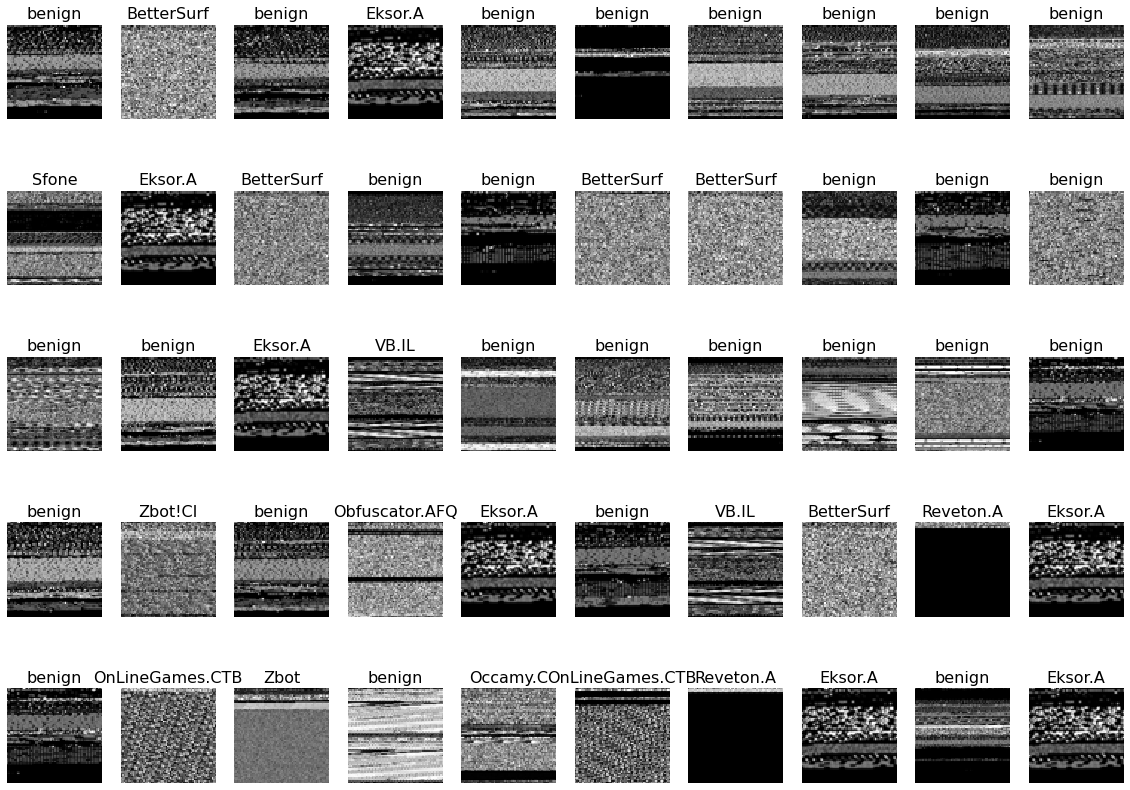

In [51]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [52]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x_axis = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [53]:
imgs = imgs / 255.0
imgs_gen = imgs_gen / 255.0

Plot data distribution among train, val. and test set

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, ReLU activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 1

In [54]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold

In [55]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [56]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  11


Building the model

In [57]:
def malware_model():
        Malware_model = Sequential()
        Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(ih,iw,chnum)))

        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Dropout(0.25))
        Malware_model.add(Flatten())
        Malware_model.add(Dense(128, activation='relu'))
        Malware_model.add(Dropout(0.5))
        Malware_model.add(Dense(50, activation='relu'))
        Malware_model.add(Dense(num_classes, activation='softmax'))
        Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        return Malware_model

In [58]:
def confusion_matrix(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [59]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


Initialize variables to keep track of performance across folds

In [60]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []
bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

# Predictions
y_pred = []
y_true = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

rw_count = []
bn_count = []

In [61]:
kfold = KFold(n_splits=n_folds, shuffle=True)

Epoch 1/35
79/79 [==============================] - 1s 7ms/step - loss: 1.3269 - accuracy: 0.5863 - val_loss: 0.6353 - val_accuracy: 0.7900

Epoch 00001: val_loss improved from inf to 0.63531, saving model to /Users/Max/Documents/GitHub/learning_curve/cgan-lc-cnn-local-v002\model.h5
Epoch 2/35
79/79 [==============================] - 0s 5ms/step - loss: 0.4148 - accuracy: 0.9033 - val_loss: 0.5672 - val_accuracy: 0.8300

Epoch 00002: val_loss improved from 0.63531 to 0.56719, saving model to /Users/Max/Documents/GitHub/learning_curve/cgan-lc-cnn-local-v002\model.h5
Epoch 3/35
79/79 [==============================] - 0s 6ms/step - loss: 0.2784 - accuracy: 0.9337 - val_loss: 0.5921 - val_accuracy: 0.8500

Epoch 00003: val_loss did not improve from 0.56719
Epoch 4/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2030 - accuracy: 0.9464 - val_loss: 0.5061 - val_accuracy: 0.8500

Epoch 00004: val_loss improved from 0.56719 to 0.50612, saving model to /Users/Max/Documents/Gi


Epoch 00002: val_loss did not improve from 0.34081
Epoch 3/35
79/79 [==============================] - 0s 5ms/step - loss: 0.3050 - accuracy: 0.9273 - val_loss: 0.5510 - val_accuracy: 0.8300

Epoch 00003: val_loss did not improve from 0.34081
Epoch 4/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2339 - accuracy: 0.9392 - val_loss: 0.4648 - val_accuracy: 0.8600

Epoch 00004: val_loss did not improve from 0.34081
Epoch 5/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2216 - accuracy: 0.9420 - val_loss: 0.6926 - val_accuracy: 0.7900

Epoch 00005: val_loss did not improve from 0.34081
Epoch 6/35
79/79 [==============================] - 0s 5ms/step - loss: 0.1951 - accuracy: 0.9464 - val_loss: 0.4360 - val_accuracy: 0.8500

Epoch 00006: val_loss did not improve from 0.34081
Epoch 7/35
79/79 [==============================] - 0s 5ms/step - loss: 0.1554 - accuracy: 0.9584 - val_loss: 0.5640 - val_accuracy: 0.8200

Epoch 00007: val_loss did not improve f

79/79 [==============================] - 0s 5ms/step - loss: 0.1489 - accuracy: 0.9528 - val_loss: 0.4652 - val_accuracy: 0.8900

Epoch 00008: val_loss did not improve from 0.34081
Epoch 9/35
79/79 [==============================] - 0s 5ms/step - loss: 0.1389 - accuracy: 0.9628 - val_loss: 0.6111 - val_accuracy: 0.8800

Epoch 00009: val_loss did not improve from 0.34081
Epoch 10/35
79/79 [==============================] - 0s 5ms/step - loss: 0.1269 - accuracy: 0.9620 - val_loss: 0.4332 - val_accuracy: 0.9000

Epoch 00010: val_loss did not improve from 0.34081
Epoch 11/35
79/79 [==============================] - 0s 5ms/step - loss: 0.1156 - accuracy: 0.9664 - val_loss: 0.6287 - val_accuracy: 0.8800

Epoch 00011: val_loss did not improve from 0.34081
Epoch 12/35
79/79 [==============================] - 0s 5ms/step - loss: 0.1060 - accuracy: 0.9640 - val_loss: 0.5566 - val_accuracy: 0.8900

Epoch 00012: val_loss did not improve from 0.34081
Epoch 13/35
79/79 [=============================


Epoch 00013: val_loss did not improve from 0.34081
Epoch 14/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0868 - accuracy: 0.9720 - val_loss: 0.4070 - val_accuracy: 0.8700

Epoch 00014: val_loss did not improve from 0.34081
Epoch 15/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0787 - accuracy: 0.9776 - val_loss: 0.4310 - val_accuracy: 0.8800

Epoch 00015: val_loss did not improve from 0.34081
Epoch 16/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0820 - accuracy: 0.9756 - val_loss: 0.5254 - val_accuracy: 0.8700

Epoch 00016: val_loss did not improve from 0.34081
Epoch 17/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.4099 - val_accuracy: 0.8500

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00017: val_loss did not improve from 0.34081
Epoch 18/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0646 - accuracy: 0.9

79/79 [==============================] - 0s 5ms/step - loss: 0.0456 - accuracy: 0.9820 - val_loss: 0.4897 - val_accuracy: 0.9000

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00019: val_loss did not improve from 0.34081
Epoch 20/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0518 - accuracy: 0.9868 - val_loss: 0.4114 - val_accuracy: 0.8900

Epoch 00020: val_loss did not improve from 0.34081
Epoch 21/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0478 - accuracy: 0.9864 - val_loss: 0.3940 - val_accuracy: 0.9200

Epoch 00021: val_loss did not improve from 0.34081
Epoch 22/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0375 - accuracy: 0.9896 - val_loss: 0.4186 - val_accuracy: 0.8900

Epoch 00022: val_loss did not improve from 0.34081
Epoch 23/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0364 - accuracy: 0.9892 - val_loss: 0.4003 - val_accuracy: 0.9000

Epoch 00023: val_


Epoch 00024: val_loss did not improve from 0.34081
Epoch 25/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0591 - accuracy: 0.9828 - val_loss: 0.5229 - val_accuracy: 0.8900

Epoch 00025: val_loss did not improve from 0.34081
Epoch 26/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0477 - accuracy: 0.9836 - val_loss: 0.5537 - val_accuracy: 0.9000

Epoch 00026: val_loss did not improve from 0.34081
Epoch 27/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0348 - accuracy: 0.9884 - val_loss: 0.5448 - val_accuracy: 0.9100

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00027: val_loss did not improve from 0.34081
Epoch 28/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0306 - accuracy: 0.9916 - val_loss: 0.5639 - val_accuracy: 0.9100

Epoch 00028: val_loss did not improve from 0.34081
Epoch 29/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0282 - accuracy: 0.9

79/79 [==============================] - 0s 5ms/step - loss: 0.0227 - accuracy: 0.9944 - val_loss: 0.3514 - val_accuracy: 0.9200

Epoch 00029: val_loss did not improve from 0.29189
Epoch 30/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0280 - accuracy: 0.9916 - val_loss: 0.3421 - val_accuracy: 0.9100

Epoch 00030: val_loss did not improve from 0.29189
Epoch 31/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.3725 - val_accuracy: 0.9100

Epoch 00031: val_loss did not improve from 0.29189
Epoch 32/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0268 - accuracy: 0.9924 - val_loss: 0.3732 - val_accuracy: 0.9100

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00032: val_loss did not improve from 0.29189
Epoch 33/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 0.3399 - val_accuracy: 0.9100

Epoch 00033: val_loss did not im


Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00034: val_loss did not improve from 0.29189
Epoch 35/35
79/79 [==============================] - 0s 5ms/step - loss: 0.0171 - accuracy: 0.9940 - val_loss: 0.5176 - val_accuracy: 0.8800

Epoch 00035: val_loss did not improve from 0.29189
Score for fold 8: loss of 0.5175861120223999; accuracy of 87.99999952316284%
Epoch 1/35
79/79 [==============================] - 1s 7ms/step - loss: 1.2708 - accuracy: 0.6279 - val_loss: 0.5199 - val_accuracy: 0.8500

Epoch 00001: val_loss did not improve from 0.29189
Epoch 2/35
79/79 [==============================] - 0s 5ms/step - loss: 0.3696 - accuracy: 0.9161 - val_loss: 0.3523 - val_accuracy: 0.9000

Epoch 00002: val_loss did not improve from 0.29189
Epoch 3/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2866 - accuracy: 0.9277 - val_loss: 0.3322 - val_accuracy: 0.9200

Epoch 00003: val_loss did not improve from 0.29189
Epoch 4/35
79/79 [==================

Epoch 1/35
79/79 [==============================] - 1s 7ms/step - loss: 1.4422 - accuracy: 0.5428 - val_loss: 0.9142 - val_accuracy: 0.7500

Epoch 00001: val_loss did not improve from 0.14538
Epoch 2/35
79/79 [==============================] - 0s 5ms/step - loss: 0.4517 - accuracy: 0.8957 - val_loss: 0.8352 - val_accuracy: 0.7700

Epoch 00002: val_loss did not improve from 0.14538
Epoch 3/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2984 - accuracy: 0.9317 - val_loss: 0.7721 - val_accuracy: 0.7600

Epoch 00003: val_loss did not improve from 0.14538
Epoch 4/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2369 - accuracy: 0.9380 - val_loss: 0.6952 - val_accuracy: 0.7900

Epoch 00004: val_loss did not improve from 0.14538
Epoch 5/35
79/79 [==============================] - 0s 5ms/step - loss: 0.2104 - accuracy: 0.9408 - val_loss: 0.6961 - val_accuracy: 0.8100

Epoch 00005: val_loss did not improve from 0.14538
Epoch 6/35
79/79 [======================

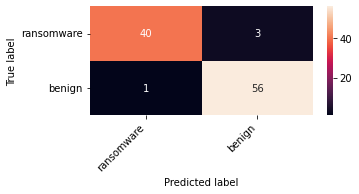

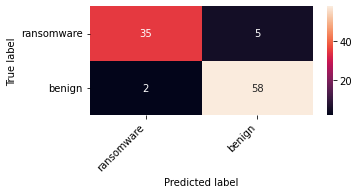

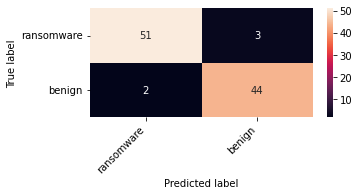

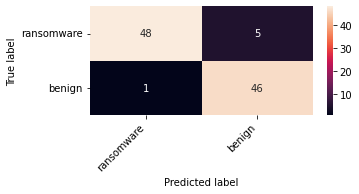

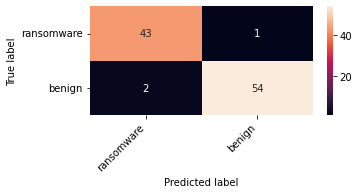

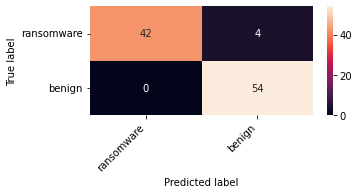

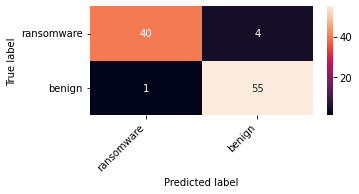

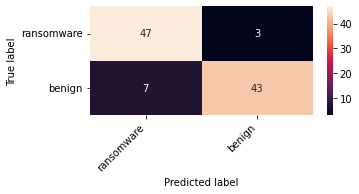

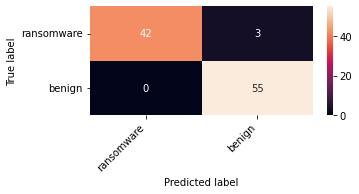

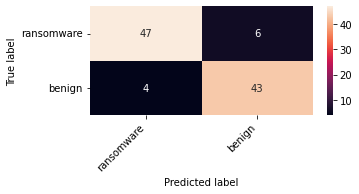

In [62]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Compile the CNN
    Malware_model = malware_model()
    
    # Add generated images to training data   
    train_images = np.concatenate((imgs[train], imgs_gen), axis = 0)
    train_labels = to_categorical(np.concatenate((np.argmax(labels[train], axis = 1), np.argmax(labels_gen, axis = 1)), axis = 0))

    # Run the CNN
    history.append(
        Malware_model.fit(
        train_images, 
        train_labels, 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    # Generate generalization metrics
    scores = Malware_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {Malware_model.metrics_names[0]} of {scores[0]}; {Malware_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(Malware_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(Malware_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    # Binary
    y_predbin = [] 
    y_truebin = []
    for count, value in enumerate(y_true2):
        if y_true2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_truebin.append(0)
        else: y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

        if y_pred2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_predbin.append(0)
        else: y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
        continue
        
    rw_count.append(len(y_truebin) - np.sum(y_truebin))
    bn_count.append(np.sum(y_truebin))
    
    # Binary confusion Matrix
    c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
    
    confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)
    
    tp.append(c_matrix_bin[0,0])
    fp.append(c_matrix_bin[0,1])
    fn.append(c_matrix_bin[1,0])
    tn.append(c_matrix_bin[1,1])
    
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    bin_tpr_per_fold.append(c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1])) #True Positive Rate
    bin_acc_per_fold.append(accuracy_score(y_truebin, y_predbin)) # Accuracy
    bin_f1_per_fold.append(f1_score(y_truebin, y_predbin, labels=0)) # F1 Score
    bin_mcc_per_fold.append(matthews_corrcoef(y_truebin, y_predbin))  # Matthews Correlation Coefficient
    
    train_distr.append((sum(train_labels)/train_labels.shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)
    

Cross validation run overview

In [63]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4682968258857727 - Accuracy: 88.99999856948853%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5715148448944092 - Accuracy: 89.99999761581421%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6517795324325562 - Accuracy: 92.00000166893005%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4414248764514923 - Accuracy: 87.99999952316284%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.47402888536453247 - Accuracy: 89.99999761581421%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.5824660062789917 - Accuracy: 91.00000262260437%
-----------------------------------------------------------------------

# Evaluating performance

Create data distribution graph (I will use around 20% of cases for benign for and the remaining 80% equally distributed across the 10 ransomware families)

In [64]:
np.array(train_distr)

array([[ 9.192646 ,  9.352518 ,  7.673861 ,  7.8337326,  7.673861 ,
         8.273381 ,  7.873701 ,  8.31335  ,  7.474021 ,  7.513989 ,
        18.82494  ],
       [ 9.31255  ,  9.31255  ,  7.673861 ,  7.673861 ,  7.713829 ,
         8.433253 ,  7.7937646,  8.353317 ,  7.5539565,  7.474021 ,
        18.705036 ],
       [ 9.032774 ,  9.11271  ,  7.753797 ,  7.753797 ,  7.713829 ,
         8.233413 ,  7.873701 ,  8.193445 ,  7.5939245,  7.474021 ,
        19.264587 ],
       [ 9.11271  ,  9.392486 ,  7.753797 ,  7.713829 ,  7.513989 ,
         8.113509 ,  7.8337326,  8.273381 ,  7.5939245,  7.474021 ,
        19.22462  ],
       [ 9.0727415,  9.51239  ,  7.753797 ,  7.7937646,  7.5939245,
         8.273381 ,  7.873701 ,  8.233413 ,  7.673861 ,  7.3541164,
        18.864908 ],
       [ 9.31255  ,  9.11271  ,  7.8337326,  7.713829 ,  7.5539565,
         8.153478 ,  7.913669 ,  8.393286 ,  7.5539565,  7.513989 ,
        18.944845 ],
       [ 9.032774 ,  9.552358 ,  7.673861 ,  7.753797 ,  7

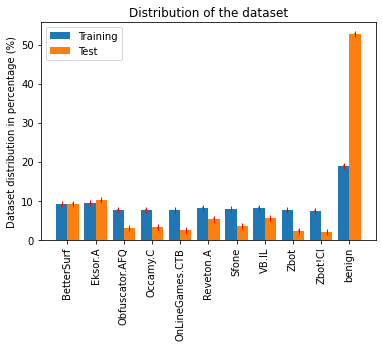

In [65]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x_axis - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x_axis - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x_axis + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x_axis + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x_axis, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [66]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1', round(np.mean(multi_f1_per_fold), 4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.add_row(['', '', ''])
t.add_row(['B-Class', "", ""])
t.add_row(['TPR    ', round(np.mean(bin_tpr_per_fold),4), round(np.std(bin_tpr_per_fold),4)])
t.add_row(['Acc    ', round(np.mean(bin_acc_per_fold),4), round(np.std(bin_acc_per_fold),4)])
t.add_row(['F1     ', round(np.mean(bin_f1_per_fold),4), round(np.std(bin_f1_per_fold),4)])
t.add_row(['MCC    ', round(np.mean(bin_mcc_per_fold),4), round(np.std(bin_mcc_per_fold),4)])
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CGAN - CNN"
print(t)

+---------------------------------------+
|       Performance of CGAN - CNN       |
| Metric   | Performance | St.Deviation |
| M-Class  |             |              |
| Acc      | 0.9         | 0.0237       |
| Loss     | 0.5039      | 0.1539       |
| Macro F1 | 0.7396      | 0.0635       |
|          |             |              |
| B-Class  |             |              |
| TPR      | 0.9215      | 0.0284       |
| Acc      | 0.943       | 0.0245       |
| F1       | 0.9453      | 0.0272       |
| MCC      | 0.886       | 0.0489       |


In [67]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [68]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [69]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CGAN-CNN across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

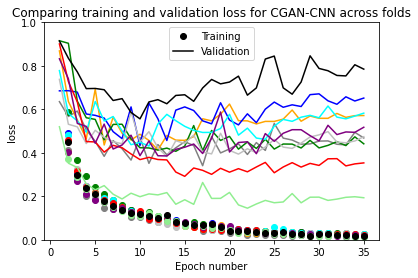

In [70]:
eval_metric(Malware_model, history, 'loss', 0,1)

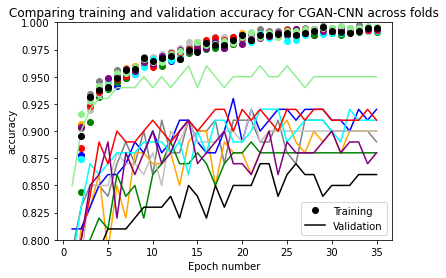

In [71]:
eval_metric(Malware_model, history, 'accuracy', 0.8,1)

# Confusion Matrix
Analysing the results

# Binary classification
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

Plot the distribution of dataset as ransomware - benign

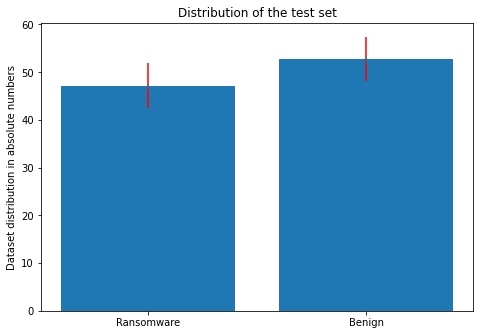

In [72]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [np.mean(rw_count), np.mean(bn_count)]
plt.title('Distribution of the test set')
plt.ylabel('Dataset distribution in absolute numbers')
ax.bar(x_lab, y_lab)
ax.errorbar(x_lab, y_lab, yerr = [np.std(rw_count), np.std(bn_count)], fmt = '|', ecolor='red')
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

Plot binary confusion matrix

In [73]:
all_y_predbin = [] 
all_y_truebin = []
for count, value in enumerate(y_true):
    if y_true[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_truebin.append(0)
    else: all_y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

    if y_pred[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_predbin.append(0)
    else: all_y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
    continue

In [74]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, name, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{(name.capitalize())} Confusion Matrix - CGAN-CNN")
    if cenv == 0:
        plt.savefig(f"{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)

In [75]:
c_matrix_bin = metrics.confusion_matrix(all_y_truebin, all_y_predbin)

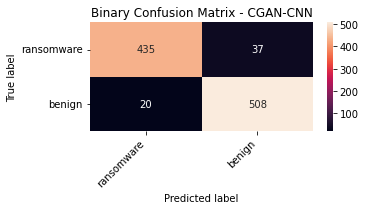

In [76]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, 'binary', figsize = (5,2), fontsize=10)

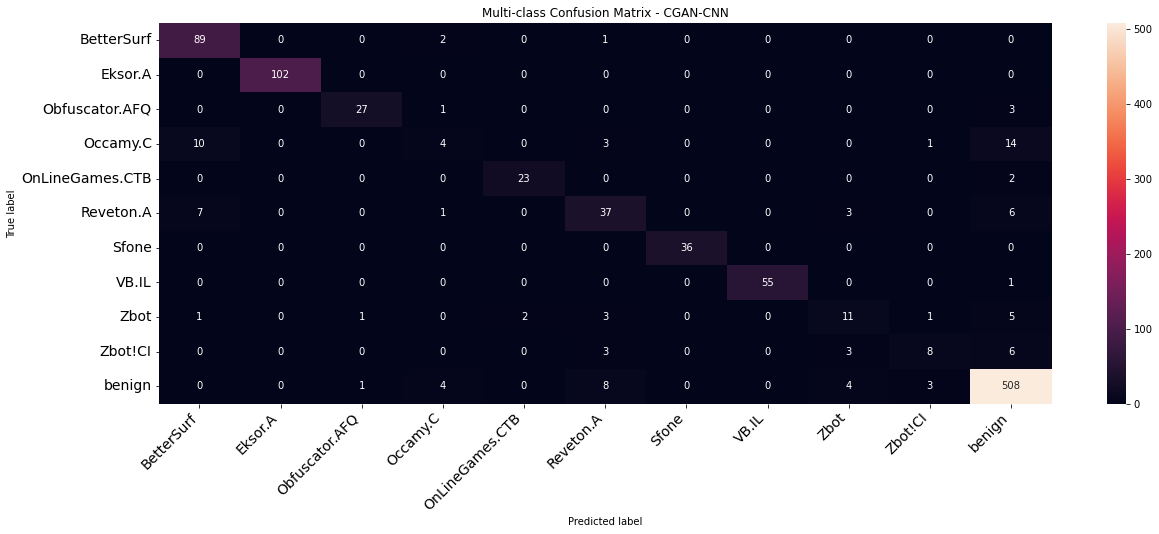

In [77]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names= batches.class_indices.keys()
confusion_matrix_bin(c_matrix, class_names, 'multi-class', figsize = (20,7), fontsize=14)